In [98]:
dataset_name = "W16_comb"
df_list = [
           "BES_Panel",
#            "BES_reduced_with_na",
#            "BESnumeric"
#            "BES_reduced",
#            "BESnumeric"
          ]

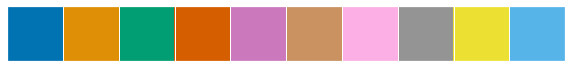

In [99]:
%matplotlib inline
import numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns
import pickle, os, gc, re
sns.set()
sns.palplot(sns.color_palette("colorblind"))
from IPython.display import display, display_html, HTML
plt.rcParams["axes.grid"] = False

import Jupyter_module_loader
from utility import *
import gaussian_kde


In [100]:
# you should clone this git to a subdirectory called 'BES_analysis_code' (in some directory - I call it BES_analysis - doesn't matter though)
# %matplotlib inline
encoding = "ISO-8859-1"

(BES_code_folder, BES_small_data_files, BES_data_folder,
 BES_output_folder, BES_file_manifest, BES_R_data_files) = setup_directories()



In [101]:
global BES_Panel, BES_numeric, BES_reduced, BES_reduced_with_na, BES_non_numeric
data_subfolder = BES_data_folder + dataset_name + os.sep

(manifest, dataset_filename, dataset_description, dataset_citation,
 dataset_start, dataset_stop, dataset_wave) = get_manifest(dataset_name, BES_file_manifest)

for df in df_list:
    if df=="BES_Panel":
        globals()[df]  = pd.read_msgpack(data_subfolder + dataset_filename.replace('.dta','.msgpack'))
    else:
        globals()[df]  = pd.read_msgpack(data_subfolder + df + '.msgpack' )
        globals()[df].replace(-1,np.nan,inplace=True)
  
# (var_type, cat_dictionary, new_old_col_names, old_new_col_names) = get_small_files(data_subfolder, encoding)

C:\ProgramData\Anaconda3\envs\BES_analysis\lib\site-packages\IPython\core\interactiveshell.py:3326: FutureWarning: The read_msgpack is deprecated and will be removed in a future version.
It is recommended to use pyarrow for on-the-wire transmission of pandas objects.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [102]:
pan_dataset_allr_values = pd.read_csv(BES_small_data_files + "pan_dataset_allr_values"+".csv")

In [103]:
global best_weight_series
def weighted_mean(series):
    return (series*best_weight_series.loc[series.index]).sum()/(best_weight_series.loc[series.index]).sum()


In [104]:
replace_dict = {'Labour Party':"LAB", 
 'United Kingdom Independence Party (UKIP)':"UKIP",
 'Labour':"LAB",
 'Conservative Party':"CON",
 'Conservative':"CON",
 'Liberal Democrats':"LD",
 'Did not vote':"DNV",
 'Scottish National Party':"SNP",
 'Scottish National Party (SNP)':"SNP",
 'British National Party (BNP)':"BNP",
 'Green Party':"GRN",
 'Liberal Democrat':"LD",
 "Don't know":"DK",
 'Some other party':"OTH",
 'Veritas':"VER",
 'Plaid Cymru':"PC",
 'Other':"OTH",
 'Respect':"RES",
 'I would not vote':"DNV",
 'No - none':"NON",
 "Brexit Party":"BXP",
 'Change UK- The Independent Group':"CUK",
 "Leave the EU":"LEAVE",
 "Stay/remain in the EU":"REMAIN",}

In [105]:
party_colour_dict = {"Lab":"red","LAB":"red",
                     "Con":'blue',"CON":'blue',"UKIP":"purple","LD":"orange",
                     "Grn":'green',"GRN":'green',
                     "BrexitParty":"cyan","BXP":'cyan',
                     "TIG":"pink","BNP":"magenta",
                     "SNP":'yellow',"PC":'olive',
                     "Remain":"yellow","REMAIN":'yellow',"Leave":"blue","LEAVE":'blue',
                     "Don't know":"grey","DK":'grey',
                     "Won't vote":"black","DNV":'black',"NON":'black',
                     "Cameron":'navy',"May":'blue',
                     "Osborne":"darkblue","Davidson":"darkblue",
                     "Boris":'cyan',"Gove":"darkviolet","Rudd":'teal',"Mogg":"black" ,"Hunt":"grey" , "Javid":"dodgerblue", 
                     "Davis":"lightblue","Mogg":'lightblue',
                     "Salmond":'goldenrod',"Sturgeon":'yellow',
                     "Miliband":'red',"Corbyn":'red',"Blair":"indianred",
                     "AlanJohnson":'pink',"Watson":"chocolate","McDonnell":"darkred","Jarvis":'tomato',"Leonard":'pink',
                     "Wood":'olive',"Price":'olive',
                     "Umunna":"lightslategrey","Berger":'darkslategrey',"Soubry":'mediumspringgreen',"Allen":"darkslategrey",
                     "Clegg":'orange',"Farron":'orange',"Cable":'orange',"Rennie":'darkorange',
                     "Farage":'purple',"SEvans":"fuchsia","Nuttall":'indigo',"Batten":'indigo',
                     "Bennett":'green',"Lucas":'limegreen',"Harvie":"green","Berry":'darkgreen',"Bartley":'limegreen',
                     "Allow many fewer":"blue",
                     "1":'cyan',"Bad for economy":'cyan',"Undermines cultural life":'cyan','Strongly disagree':'cyan','It is completely necessary':'cyan',
                     "2":'yellow','Disagree':'yellow','It is important but not absolutely  necessary':'yellow',
                     "3":'olive','Neither agree nor disagree':'olive','It is not necessary but it would be desirable':'olive',
                     "4":'green', 'Agree':'green','It is completely unnecessary':'green',
                     "5":"limegreen",'Strongly agree':'limegreen',
                     "6":"orange",
                     "7":'brown',"Good for economy":'brown',"Enriches cultural life":'brown',
                     "8":'pink',
                     "9":'purple',
                     "Allow many more":'red',
                     }

# ['It is completely necessary','It is important but not absolutely  necessary','It is not necessary but it would be desirable','It is completely unnecessary',"Don't know"]

In [106]:
linear_colour_list = ['blue','cyan','yellow','olive','green','limegreen','orange','brown','pink','purple','red']
howToReduceDeficit_cats = ['Only by increasing taxes','Mainly by increasing taxes, but also by cutting spending','An equal balance of spending cuts and tax increases', 
'Mainly by cutting spending, but with some tax increases','Only by cutting spending',"Don't know"   ]
party_colour_dict.update( {x:k for x,k in zip(howToReduceDeficit_cats,linear_colour_list[0:len(howToReduceDeficit_cats)+1]) if x != "Don't know"} )

leftRight_cats = ['Left', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'Right',
       "Don't know"]
party_colour_dict.update( {x:k for x,k in zip(leftRight_cats,linear_colour_list[0:len(leftRight_cats)+1]) if x != "Don't know"} )

In [12]:
min_sample_size = 100

In [79]:
search(BES_Panel,"leftRight")

leftRightW1     30336
leftRightW2     30240
leftRightW3     27828
leftRightW4     31442
leftRightW5     30833
leftRightW6     30151
leftRightW7     30895
leftRightW8      6053
leftRightW9      7442
leftRightW10    30237
leftRightW11    30956
leftRightW12    34394
leftRightW13    31136
leftRightW14    31063
leftRightW15    30842
leftRightW16    37959
dtype: int64

In [80]:
[int(x.split("W")[1]) for x in search(BES_Panel,"leftRight").index]

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]

In [92]:
BES_Panel["leftRightW1"].cat.categories

Index(['1', '2', '3', '4', '5', '6', '7', '8', '9', 'Don't know', 'Left',
       'Right'],
      dtype='object')

In [108]:
df1

leftRightW1,1,2,3,4,6,7,8,9,Left,Right
0,0,0,0,0,0,0,1,0,0,0
1,0,0,0,0,0,0,1,0,0,0
2,0,0,0,1,0,0,0,0,0,0
3,0,0,0,0,0,0,0,1,0,0
4,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
92582,0,0,0,0,0,0,0,0,0,0
92583,0,0,0,0,0,0,0,0,0,0
92584,0,0,0,0,0,0,0,0,0,0
92585,0,0,0,0,0,0,0,0,0,0


In [9]:
from scipy import interpolate

In [109]:
# %%time
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from matplotlib import colors
import matplotlib.patches as mpatches

sns.set(font_scale=2.5)

wave_descriptions = BES_file_manifest[BES_file_manifest["Only_or_Combined"]=="Only"][["Wave No","Friendlier_Description"]].set_index("Wave No")

granularity = 21
x_axis = pan_dataset_allr_values.columns[0].replace("200",str(granularity-1)).replace("{uniform}","")
y_axis = pan_dataset_allr_values.columns[1].replace("200",str(granularity-1)).replace("{uniform}","")
pan_dataset_allr_values[x_axis] = pd.qcut( pan_dataset_allr_values[pan_dataset_allr_values.columns[2]], q=granularity, labels=range(0,granularity))
pan_dataset_allr_values[y_axis] = pd.qcut( pan_dataset_allr_values[pan_dataset_allr_values.columns[3]], q=granularity, labels=range(0,granularity))
# pan_dataset_allr_values[x_axis] = pd.qcut( pan_dataset_allr_values["original_lr_scale"], q=granularity, labels=range(0,granularity))
# pan_dataset_allr_values[y_axis] = pd.qcut( pan_dataset_allr_values["original_al_scale"], q=granularity, labels=range(0,granularity))

output_granularity=800
min_sample_size =100    
smoothing = 50.0
pop_gridlines = False
max_z_size = 1.0
normalize_heights = False
use_bes_weights = True
bes_wave_based = True
break_single_variable = True
abbreviate_variables = False
drop_cats = ["Don't know","5"]

# stub_var = "partyId"
stub_var = "leftRight"
title_base = "In politics people sometimes talk of left and right.\nWhere would you place yourself on the following scale?\n(0-Left...10-Right)"
scale_text = 'Probability to choose option'
cbar_text = "Dominant Option (in territory size order)"

#['Bad for economy', '2', '3', '4', '5', '6', 'Good for economy',
#        "Don't know"]
# search(BES_Panel,"partyMemberNow")
# [1,2,3,4,5, 7, 9, 13]
if use_bes_weights:
    aggfunc = weighted_mean
else:
    aggfunc = np.mean

# region = "England"
region = None
if region is not None:
    specific_mask = (BES_Panel["country"]==region)# & (BES_Panel["profile_eurefvote"]=="Leave the EU")
else:
    specific_mask = BES_Panel["id"].notnull()
# ["W2","W6","W8","W12","W14","W16"]
max_wave = 17
skip_waves = [5]
skip_waves = [ 1, 2, 3, 4, 5, 6, 7, 8, 9, 10,11,13,15 ]
skip_waves = [1,2,3,4,5, 7, 9, 13]
skip_waves = [5,6,9,12]
# [1, 2, 3, 4, 7, 8, 10, 11][4, 6, 10, 11, 15]
skip_waves = [1,2,3, 5, 7,8, 9, 12,13,14,16 ]
skip_waves = []
wave_list = ["W"+str(x) for x in list(range(1,max_wave)) if x not in skip_waves]
# wave_list = [str(x) for x in [2005,2010,2015,2017]]
for wave in wave_list:
    if bes_wave_based:
        wave_no = int(wave.replace("W",""))
        title_extra = "\n"+wave_descriptions.loc[wave_no].values[0]#+"; "+region#+"&Leave-2016"
    else:
        title_extra = "\n"+wave#+"; "+region#+"&Leave-2016"

# treatment = "brexitself_surface"
#     treatment = "ptv_surface"+wave+"_" + region# + "_LEAVE2016"
    treatment = stub_var+"_minusDKs"+"_surface"+wave#+"originalPC"#+"_"
    
    if region is not None:
            treatment = treatment+"_"+region
            title_extra = title_extra+"; "+region
    output_subfolder = create_subdir(BES_output_folder, treatment)

# party_list = ["Lab","Con","LD","Grn","UKIP","TIG","BrexitParty"]
# party_list = ["ptv"+x for x in party_list]
# party_list = ["brexitSelf"]
    if break_single_variable:
        
        if drop_cats:
            df1 = pd.get_dummies(BES_Panel[stub_var+wave].cat.remove_categories(drop_cats))
        else:
            df1 = pd.get_dummies(BES_Panel[stub_var+wave])
        mask = BES_Panel[stub_var+wave].notnull() & specific_mask
#     eurevote_col_replace_dict = {"Don't know":"Don't know", "I would/will not vote":"Won't vote", "Leave the EU":"Leave",
#                   "Stay/remain in the EU":"Remain"}
        if abbreviate_variables:
            df1.columns = [replace_dict[x] for x in df1.columns]
        party_list = df1.columns
    else:
    ## sample size!
#         temp = match(BES_Panel,"like(.*)"+wave+"$", mask = specific_mask)
#         party_list = list(temp[temp>min_sample_size].index)
#         party_list = [x for x in party_list if re.match("like(.*)W\d+",x).groups()[0] in ["Con","Lab","SNP","PC","UKIP","Grn","BNP","LD","BrexitParty","TIG"]]
        
        temp = match(BES_Panel,"like(.*)"+wave+"$", mask = specific_mask)
        party_list = list(temp[temp>min_sample_size].index)
        party_list = [x for x in party_list if re.match("like(.*)W\d+",x).groups()[0] not in ["CandA","CandB","SNPExtra","Con","Lab","SNP","PC","UKIP","Grn","BNP","LD","BrexitParty","TIG","DUP"]]        
        
        print(party_list)
#     temp = match(BES_Panel,"ptv.*"+wave+"$", mask = specific_mask)
#     party_list = list(temp[temp>min_sample_size].index)
    
    

    
    # specific_mask = 1

    interp_dict = {}

    largestN = 0


    for party in party_list:
        print(party)
    #     like_var = "ptv"+party
        like_var = party

        like_name = "probability to vote "+party
#         scale_text = ' 0-Very Unlikely, 10-Very Likely'
        title_text = title_base+like_var+title_extra
#         title_text = "Which party do you feel closest to: "+like_var+"?"+title_extra
        

    #     like_name = "Some people want to leave the European Union immediately without a deal.\nOther people would like to cancel Brexit and remain in the EU.\nWhere would you place yourself and the political parties on this scale?"
    #     scale_text = ' 0-Leave the EU without a deal, 10-Remain in the EU'    
    #     title_text = like_name

        # fix disordered categories!
        if "ptv" in like_var:
            BES_Panel[[x for x in BES_Panel.columns if like_var in x]] = \
                BES_Panel[[x for x in BES_Panel.columns if like_var in x]]\
                    .apply(lambda x: x.cat.reorder_categories(['Very unlikely','1', '2', '3', '4', '5', '6', '7', '8', '9',
                       'Very likely', "Don't know" ]))    
        elif "like" in like_var:
            BES_Panel[[x for x in BES_Panel.columns if like_var in x]] = \
                BES_Panel[[x for x in BES_Panel.columns if like_var in x]]\
                    .apply(lambda x: x.cat.reorder_categories(['Strongly dislike','1', '2', '3', '4', '5', '6', '7', '8', '9', "Don't know",
        'Strongly like']))                
        elif "immigEcon" in like_var:
            BES_Panel[[x for x in BES_Panel.columns if like_var in x]] = \
                BES_Panel[[x for x in BES_Panel.columns if like_var in x]]\
                    .apply(lambda x: x.cat.reorder_categories(['Bad for economy', '2', '3', '4', '5', '6', 'Good for economy',
       "Don't know"]))  
        elif "immigCultural" in like_var:
            BES_Panel[[x for x in BES_Panel.columns if like_var in x]] = \
                BES_Panel[[x for x in BES_Panel.columns if like_var in x]]\
                    .apply(lambda x: x.cat.reorder_categories(['Undermines cultural life', '2', '3', '4', '5', '6',
       'Enriches cultural life', "Don't know"]))     
        elif "immigrantsWelfareState" in like_var:
            BES_Panel[[x for x in BES_Panel.columns if like_var in x]] = \
                BES_Panel[[x for x in BES_Panel.columns if like_var in x]]\
                    .apply(lambda x: x.cat.reorder_categories(['Strongly disagree', 'Disagree', 'Neither agree nor disagree',
       'Agree','Strongly agree',  "Don't know"]))  
        elif "deficitReduce" in like_var:
            BES_Panel[[x for x in BES_Panel.columns if like_var in x]] = \
                BES_Panel[[x for x in BES_Panel.columns if like_var in x]]\
                    .apply(lambda x: x.cat.reorder_categories(['It is completely necessary','It is important but not absolutely  necessary','It is not necessary but it would be desirable','It is completely unnecessary',"Don't know"]))  
        elif "howToReduceDeficit" in like_var:
            BES_Panel[[x for x in BES_Panel.columns if like_var in x]] = \
                BES_Panel[[x for x in BES_Panel.columns if like_var in x]]\
                    .apply(lambda x: x.cat.reorder_categories(howToReduceDeficit_cats))  
        elif "leftRight" in like_var:
            BES_Panel[[x for x in BES_Panel.columns if like_var in x]] = \
                BES_Panel[[x for x in BES_Panel.columns if like_var in x]]\
                    .apply(lambda x: x.cat.reorder_categories(leftRight_cats))
            
   


        # mean across all waves
    #     mean_like_Corbyn = BES_Panel[[x for x in BES_Panel.columns if like_var in x]]\
    #     .replace("Don't know",np.nan).apply(lambda x:x.cat.codes).replace(-1,np.nan).mean(axis=1)

#         mean_like_Corbyn = BES_Panel[[like_var]]\
#         .replace("Don't know",np.nan).apply(lambda x:x.cat.codes).replace(-1,np.nan).mean(axis=1)
        if break_single_variable:
            mean_like_Corbyn = df1[like_var]
        else:
            mean_like_Corbyn = BES_Panel[[like_var]]\
            .replace("Don't know",np.nan).apply(lambda x:x.cat.codes).replace(-1,np.nan).mean(axis=1)          
            mask = mean_like_Corbyn.notnull() & specific_mask

#         
        N_equal_text = " (N="+str(mask.sum())+")"
        
        global best_weight_series
        best_weight_variable = search(BES_Panel,"wt_",mask=mask).sort_values(ascending=False).index[0]
        best_weight_series = BES_Panel[best_weight_variable]

        likeCorbyn_heatmap = pd.crosstab(index = pan_dataset_allr_values[y_axis][mask],
                    columns = pan_dataset_allr_values[x_axis][mask],
                    values = mean_like_Corbyn[mask],
                    aggfunc = aggfunc)

        plt.figure(figsize = (16,10))
        ax = sns.heatmap(data = likeCorbyn_heatmap.replace(np.nan,-1),
                    cbar_kws={'label': like_var+ scale_text})
        ax.invert_yaxis()

        plt.xlim([0,granularity])
        plt.ylim([0,granularity])
        plt.xlabel(x_axis);
        plt.ylabel(y_axis);
        plt.title(title_text+N_equal_text)
        plt.savefig(BES_output_folder + treatment + os.sep + like_var +"_by_PC_heatmap" + ".png",
                   bbox_inches='tight')
        plt.close()

        #### INTERPOLATE

        size = likeCorbyn_heatmap.columns.max()
        x,y = np.mgrid[ 0:size:granularity*1j, 0:size:granularity*1j ]
        z =  likeCorbyn_heatmap.values.flatten()
        non_null_mask = ~np.isnan(z)
        x = x.flatten()[non_null_mask]
        y = y.flatten()[non_null_mask]
        z = z[non_null_mask]
        print("There are " + str(np.sum(~non_null_mask)) + " nulls") 
        interp_dict[party]=interpolate.Rbf(x,y,z,function='linear',smooth=smoothing)


        grid=np.mgrid[0:size:1j*output_granularity,
                       0:size:1j*output_granularity]
        result=interp_dict[party](grid[0,:,:],grid[1,:,:]);
        plt.figure(figsize=(14,14));
        img = plt.imshow(result,interpolation = 'none',origin ='lower',
                  extent = (0,granularity-1,0,granularity-1)); #Apparently nice smooth linear-ish interpolation
        plt.grid(None)
        plt.locator_params(nbins=5)
        cbar = plt.colorbar(img,shrink=0.5, aspect=5, label =  like_var+ scale_text );#, title = "\n".join(scale_text.split(",")) );
        plt.xlabel(x_axis);
        plt.ylabel(y_axis);
        plt.title(title_text+N_equal_text)
        plt.savefig(BES_output_folder + treatment + os.sep + like_var +"_by_PC_interpolated" + ".png",
                   bbox_inches='tight')
        plt.close()



        ### 3D Surface

        X,Y = grid
        Z = result.reshape(X.shape)
        # this seems to flip the axes!
        # Plot the surface.
        fig = plt.figure(figsize=(14,14));

        ax = fig.add_subplot(111, projection='3d')
        surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,
                               linewidth=0, antialiased=False)

        ax.set_title(title_text+N_equal_text, fontsize=18)
        # Customize the z axis.
        ax.set_zlim(0, max_z_size);
#         ax.zaxis.set_major_locator(LinearLocator(10));
        plt.xlabel(y_axis, fontsize=14);
        plt.ylabel(x_axis, fontsize=14);
        ax.set_zlabel(like_var+ scale_text, fontsize=14);
        plt.locator_params(nbins=5)
        ax.tick_params(axis='both', which='major', labelsize=14)
        ax.tick_params(axis='both', which='minor', labelsize=14)


        # Add a color bar which maps values to colors.
        fig.colorbar(surf, shrink=0.5, aspect=5);

    #     fig.show();
        fig.savefig(BES_output_folder + treatment + os.sep + like_var +"_by_PC_3D" + ".png",
                   bbox_inches='tight')
        plt.close()
        
        if mask.sum()>largestN:
            largestN = mask.sum()
        

    ###################

    
    overall_N_equal_text = " (N="+str(largestN)+")"

#     output_granularity=500
    grid=np.mgrid[0:size:1j*output_granularity,
                   0:size:1j*output_granularity]

    df = pd.DataFrame()
    for party in party_list:
        df[party]=interp_dict[party](grid[0,:,:],grid[1,:,:]).flatten()

    #df["max"] = df.max(axis=1)
    # df["leading_party"] = df.apply(lambda x: x.index[x[df.columns]==x["max"]][0],axis=1) # slow ~ 30s


    df["leading_party"] = df.idxmax(axis=1)
    df["max"] = df.max(axis=1)/max_z_size
    surf_min = df["max"].min()
    surf_max = df["max"].max()
    if normalize_heights:       
        df["max"] = ( df["max"]-surf_min ) / (surf_max-surf_min )

    ######################

    dominant_parties = list(df["leading_party"].value_counts().index)
    display(df["leading_party"].value_counts())

# "Remain":"yellow","Leave":"blue",

    legend_patch_list = []

    count = 0
    colour_list = []
    repl_dict = {}
    for party in dominant_parties:
        repl_dict[party] = count

        party_name = party.replace("ptv","").split("W")[0]
        if abbreviate_variables:
            party_name = re.match(stub_var+"(.*)W\d+",party).groups()[0]
#         party.replace("like","").split("W")[0]
        colour = party_colour_dict[ party_name ]
        colour_list.append( colour )
        legend_patch_list.append( mpatches.Patch(color=colour, label=party_name) )
        count=count+1

    #######################


#     cmap = colors.ListedColormap(colour_list)
#     bounds=list(range(0,np.max(list(repl_dict.values()))+2))

#     norm = colors.BoundaryNorm(bounds, cmap.N)
#     colour_list = ["yellow","blue"]
    

    from matplotlib import colors as mcolors
    color_dict = dict(mcolors.BASE_COLORS, **mcolors.CSS4_COLORS)


#     colour_list = ['yellow','blue']
    eta = .001
    cdict = {'red':[],'green':[],'blue':[],'alpha':[]}

    n = len(colour_list)
    anchor_pts = np.linspace(0.0,1.0,n+1)

    for col_no in range(0,n):
        x = anchor_pts[col_no]
        col = mcolors.to_rgba( color_dict[ colour_list[col_no] ] )
        cdict['red'].append(   (x,col[0],col[0]) )
        cdict['green'].append( (x,col[1],col[1]) )
        cdict['blue'].append(  (x,col[2],col[2]) )
        cdict['alpha'].append(  (x,0.0,0.0 ) )

        x = anchor_pts[col_no+1]-eta
        if col_no ==(n-1):
            x = x+eta
        col = mcolors.to_rgba( color_dict[ colour_list[col_no] ] )
        cdict['red'].append(   (x,col[0],col[0]) )
        cdict['green'].append( (x,col[1],col[1]) )
        cdict['blue'].append(  (x,col[2],col[2]) )
        cdict['alpha'].append(  (x,1.0,1.0 ) )

    plt.register_cmap(name='test', data=cdict)

    df["leading_party"] = df["leading_party"].replace(repl_dict).astype('float')
#     df["leading_party"] = 1.0-df["leading_party"]

    res = df["leading_party"].values.reshape((output_granularity,output_granularity))
    res = (df["leading_party"]+df["max"]).values.reshape((output_granularity,output_granularity))

    ######################
#     plt.rcParams["axes.grid"] = False
#     title_text = "Which parties have the highest Probability To Ever Vote\nat any given Political Compass position?"+title_extra
#     title_text = "How would/did/would you vote (again) in an EU referendum?"+title_extra
#     title_text = "How would you vote in the next General Election?"+title_extra
    patchwork_title_text = title_base+title_extra
    

    # make a color map of fixed colors
    plt.figure(figsize=(14,14));
    # tell imshow about color map so that only set colors are used
    print(np.min(res),np.max(res),len(colour_list))
    img = plt.imshow(res/len(colour_list), origin='lower',
                  cmap='test',interpolation='none',norm=None,vmin=0.0, vmax=1.0,
                  extent = (0,granularity-1,0,granularity-1) )
#                         cmap=cmap, norm=norm,
    from matplotlib import cm
    import matplotlib.ticker as ticker
    def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
        new_cmap = colors.LinearSegmentedColormap.from_list(
            'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
            cmap(np.linspace(minval, maxval, n)))
        return new_cmap

    cmap = plt.get_cmap('test')
    new_cmap = truncate_colormap(cmap, 0.0, 1.0/n, 1000)    
    
    plt.colorbar(cm.ScalarMappable(norm=cm.colors.Normalize(vmax=surf_min*max_z_size, vmin=surf_max*max_z_size),
                                   cmap=new_cmap),shrink=0.5, label = scale_text, format=ticker.FormatStrFormatter('%.1g'))
    
    plt.xlabel(x_axis);
    plt.ylabel(y_axis);
#     plt.rcParams["axes.grid"] = False
    plt.title(patchwork_title_text+overall_N_equal_text)
    plt.locator_params(nbins=5)
    plt.grid(None)

    if pop_gridlines==True:

        hmax = sns.kdeplot(pan_dataset_allr_values[x_axis][specific_mask],pan_dataset_allr_values[y_axis][specific_mask],
                           cut=0, alpha=.2)
        hmax.collections[0].set_alpha(0)


    plt.legend(handles=legend_patch_list, bbox_to_anchor=(0.5, -0.095),loc="upper center",
               fancybox=True, shadow=True, title=cbar_text, ncol=5, fontsize=14)
    plt.annotate(dataset_citation, (0,0), (0, -170),
                     xycoords='axes fraction', textcoords='offset points', va='top', fontsize = 7) ;     


    plt.savefig(BES_output_folder + treatment + os.sep + "all_ptv_surfaces"+"_by_PC_territory" + ".png",
                bbox_inches='tight')
    plt.close()

    ######################################

    X,Y = grid
    Z = df["max"].values.reshape(X.shape)
    # this seems to flip the axes!
    # Plot the surface.
    fig = plt.figure(figsize=(14,14));

    ax = fig.add_subplot(111, projection='3d')
    surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,
                           linewidth=0, antialiased=False)

    ax.set_title(title_text+overall_N_equal_text, fontsize=18)

    # Customize the z axis.
    ax.set_zlim(0, max_z_size);
#     ax.zaxis.set_major_locator(LinearLocator(10));
    plt.xlabel(y_axis, fontsize=14);
    plt.ylabel(x_axis, fontsize=14);
    plt.locator_params(nbins=5)
    ax.tick_params(axis='both', which='major', labelsize=14)
    ax.tick_params(axis='both', which='minor', labelsize=14)
    ax.set_zlabel(patchwork_title_text+overall_N_equal_text, fontsize=14);
    
    fig.savefig(BES_output_folder + treatment + os.sep + "all_ptv_surfaces" +"_by_PC_3D" + ".png",
               bbox_inches='tight')
    plt.close()
    ################

    plt.figure(figsize=(14,14));
    img = plt.imshow(Z,interpolation = 'none',origin ='lower',
              extent = (0,granularity-1,0,granularity-1)); #Apparently nice smooth linear-ish interpolation
    plt.grid(None)
    plt.locator_params(nbins=5)
    cbar = plt.colorbar(img,shrink=0.5, aspect=5, label = scale_text);
    plt.xlabel(x_axis);
    plt.ylabel(y_axis);
    plt.title(patchwork_title_text+overall_N_equal_text)
    plt.savefig(BES_output_folder + treatment + os.sep + "all_ptv_surfaces" +"_by_PC_interpolated" + ".png",
                bbox_inches='tight')
    plt.close()
gc.collect()

# plt.xticks(fontsize=14, rotation=90)

1
There are 0 nulls
2
There are 0 nulls
3
There are 0 nulls
4
There are 0 nulls
6
There are 0 nulls
7
There are 0 nulls
8
There are 0 nulls
9
There are 0 nulls
Left
There are 0 nulls
Right
There are 0 nulls


3    276453
7    201479
8     80660
2     44278
6     32806
4      4324
Name: leading_party, dtype: int64

0.06551769618517746 5.182998665394278 6
1
There are 0 nulls
2
There are 0 nulls
3
There are 0 nulls
4
There are 0 nulls
6
There are 0 nulls
7
There are 0 nulls
8
There are 0 nulls
9
There are 0 nulls
Left
There are 0 nulls
Right
There are 0 nulls


3    315395
7    246009
8     60917
2     17679
Name: leading_party, dtype: int64

0.0767113104472602 3.269769968719362 4
1
There are 0 nulls
2
There are 0 nulls
3
There are 0 nulls
4
There are 0 nulls
6
There are 0 nulls
7
There are 0 nulls
8
There are 0 nulls
9
There are 0 nulls
Left
There are 0 nulls
Right
There are 0 nulls


3    308018
7    214763
8     60290
6     37771
2     19158
Name: leading_party, dtype: int64

0.07319548433701159 4.2851271260016 5
1
There are 0 nulls
2
There are 0 nulls
3
There are 0 nulls
4
There are 0 nulls
6
There are 0 nulls
7
There are 0 nulls
8
There are 0 nulls
9
There are 0 nulls
Left
There are 0 nulls
Right
There are 0 nulls


3    312722
7    202194
8    110546
2     11949
6      2589
Name: leading_party, dtype: int64

0.07211455026297507 4.136219811392436 5
1
There are 0 nulls
2
There are 0 nulls
3
There are 0 nulls
4
There are 0 nulls
6
There are 0 nulls
7
There are 0 nulls
8
There are 0 nulls
9
There are 0 nulls
Left
There are 0 nulls
Right
There are 0 nulls


3    287479
7    155557
8     96233
6     77740
2     22991
Name: leading_party, dtype: int64

0.06966158992054577 4.281533291026666 5
1
There are 0 nulls
2
There are 0 nulls
3
There are 0 nulls
4
There are 0 nulls
6
There are 0 nulls
7
There are 0 nulls
8
There are 0 nulls
9
There are 0 nulls
Left
There are 0 nulls
Right
There are 0 nulls


3    300885
7    247076
8     46218
6     25584
2     10391
4      9846
Name: leading_party, dtype: int64

0.06526101023301767 5.174847987228194 6
1
There are 0 nulls
2
There are 0 nulls
3
There are 0 nulls
4
There are 0 nulls
6
There are 0 nulls
7
There are 0 nulls
8
There are 0 nulls
9
There are 0 nulls
Left
There are 0 nulls
Right
There are 0 nulls


3    326958
7    177037
6     69688
8     62836
2      3481
Name: leading_party, dtype: int64

0.07746072750973357 4.285004329464439 5
1
There are 0 nulls
2
There are 0 nulls
3
There are 0 nulls
4
There are 0 nulls
6
There are 0 nulls
7
There are 0 nulls
8
There are 0 nulls
9
There are 0 nulls
Left
There are 0 nulls
Right
There are 0 nulls


3    297935
7    187205
8     75873
4     45458
6     28034
2      5495
Name: leading_party, dtype: int64

0.07892870443179922 5.298345913886788 6
1
There are 0 nulls
2
There are 0 nulls
3
There are 0 nulls
4
There are 0 nulls
6
There are 0 nulls
7
There are 0 nulls
8
There are 0 nulls
9
There are 0 nulls
Left
There are 0 nulls
Right
There are 0 nulls


3    254503
7    140514
8    101886
4     80337
6     60679
2      2081
Name: leading_party, dtype: int64

0.07236987563495886 5.209104620297082 6
1
There are 0 nulls
2
There are 0 nulls
3
There are 0 nulls
4
There are 0 nulls
6
There are 0 nulls
7
There are 0 nulls
8
There are 0 nulls
9
There are 0 nulls
Left
There are 0 nulls
Right
There are 0 nulls


3    288730
7    231252
6     63129
8     48656
2      4928
4      3305
Name: leading_party, dtype: int64

0.06266294599430425 5.0860786263906395 6
1
There are 0 nulls
2
There are 0 nulls
3
There are 0 nulls
4
There are 0 nulls
6
There are 0 nulls
7
There are 0 nulls
8
There are 0 nulls
9
There are 0 nulls
Left
There are 0 nulls
Right
There are 0 nulls


3    288234
7    224811
8     69915
6     25603
4     19813
2     11624
Name: leading_party, dtype: int64

0.06690297884240405 5.273204950007628 6
1
There are 0 nulls
2
There are 0 nulls
3
There are 0 nulls
4
There are 0 nulls
6
There are 0 nulls
7
There are 0 nulls
8
There are 0 nulls
9
There are 0 nulls
Left
There are 0 nulls
Right
There are 0 nulls


3    289047
7    198760
6     82173
8     47565
2     13943
4      8512
Name: leading_party, dtype: int64

0.05844325961029276 5.1442246279306865 6
1
There are 0 nulls
2
There are 0 nulls
3
There are 0 nulls
4
There are 0 nulls
6
There are 0 nulls
7
There are 0 nulls
8
There are 0 nulls
9
There are 0 nulls
Left
There are 0 nulls
Right
There are 0 nulls


3    290091
7    197578
6     76835
8     28820
4     28357
2     18319
Name: leading_party, dtype: int64

0.06388018496922909 5.301284358399536 6
1
There are 0 nulls
2
There are 0 nulls
3
There are 0 nulls
4
There are 0 nulls
6
There are 0 nulls
7
There are 0 nulls
8
There are 0 nulls
9
There are 0 nulls
Left
There are 0 nulls
Right
There are 0 nulls


3    320515
7    193658
6     97189
8     26447
4      2191
Name: leading_party, dtype: int64

0.06737971044724025 4.153436682238892 5
1
There are 0 nulls
2
There are 0 nulls
3
There are 0 nulls
4
There are 0 nulls
6
There are 0 nulls
7
There are 0 nulls
8
There are 0 nulls
9
There are 0 nulls
Left
There are 0 nulls
Right
There are 0 nulls


3    300666
7    206382
6     93013
8     28816
2      9393
4      1730
Name: leading_party, dtype: int64

0.06495091663242292 5.070804618017984 6
Left
There are 0 nulls
1
There are 0 nulls
2
There are 0 nulls
3
There are 0 nulls
4
There are 0 nulls
6
There are 0 nulls
7
There are 0 nulls
8
There are 0 nulls
9
There are 0 nulls
Right
There are 0 nulls


3    295341
7    252315
6     92344
Name: leading_party, dtype: int64

0.06772896618839147 2.1762143124818847 3


0

In [30]:
max_wave
# list(range(1,max_wave))

17

In [31]:
skip_waves = [5, 6,  9, 12]
wave_list = ["W"+str(x) for x in list(range(1,max_wave)) if x not in skip_waves]

In [25]:
search(BES_Panel,"immigEcon")

immigEconW1     30335
immigEconW2     30240
immigEconW3     28114
immigEconW4     31444
immigEconW7     30895
immigEconW8     33502
immigEconW10    30237
immigEconW11    30956
immigEconW13    31136
immigEconW14    31063
immigEconW15    30842
immigEconW16    37959
dtype: int64

In [111]:
### build animated gif


filename_list = []
sorted_wavelist = []
# skip_waves = [ 1, 3, 4, 5, 7, 9, 10,11,13,15 ]
for wave in wave_list:
    
    wave_no = int(wave.replace("W",""))
    sorted_wavelist.append(wave_no)
#     treatment = "ptv_surface"+wave+"_" + region + "_LEAVE2016"
    treatment = stub_var+"_surface"+wave#+"originalPC"#+"_"
    treatment = stub_var+"_minusDKs"+"_surface"+wave
    if region is not None:
            treatment = treatment+"_"+region
#     treatment = "eurefvote_surface"+wave+"originalPC"
#     C:\Users\Marios\Documents\GitHub\BES_analysis\BES_analysis_output\leftRight_minusDKs_surfaceW16
    filename_list.append( BES_output_folder + treatment + os.sep + "all_ptv_surfaces"+"_by_PC_territory" + ".png" )



import imageio


images = []
for filename in filename_list:
    images.append(imageio.imread(filename))
images.append(imageio.imread(filename)) # last slide delay doesn't seem to be being respected on twitter - so add the last one twice
sorted_wavelist.append(wave_no)
imageio.mimsave(BES_output_folder + treatment + os.sep +'animated_ptv_surfaces.gif', images,'GIF',
                duration=[6.0 if x==np.min( sorted_wavelist ) or x==np.max( sorted_wavelist ) else 3.0 for x in sorted_wavelist])  

In [29]:
filename_list

['../BES_analysis_output/immigEcon_surfaceW1\\all_ptv_surfaces_by_PC_territory.png',
 '../BES_analysis_output/immigEcon_surfaceW2\\all_ptv_surfaces_by_PC_territory.png',
 '../BES_analysis_output/immigEcon_surfaceW3\\all_ptv_surfaces_by_PC_territory.png',
 '../BES_analysis_output/immigEcon_surfaceW4\\all_ptv_surfaces_by_PC_territory.png',
 '../BES_analysis_output/immigEcon_surfaceW7\\all_ptv_surfaces_by_PC_territory.png',
 '../BES_analysis_output/immigEcon_surfaceW8\\all_ptv_surfaces_by_PC_territory.png',
 '../BES_analysis_output/immigEcon_surfaceW10\\all_ptv_surfaces_by_PC_territory.png',
 '../BES_analysis_output/immigEcon_surfaceW11\\all_ptv_surfaces_by_PC_territory.png']

In [105]:
pd.get_dummies(BES_Panel["monarchW8"])
pd.get_dummies(BES_Panel["euRefVoteW8"])

euRefVoteW8,Don't know,I would/will not vote,Leave the EU,Stay/remain in the EU
0,0,0,1,0
1,0,0,1,0
2,0,0,0,0
3,0,0,0,0
4,0,0,0,0
...,...,...,...,...
92582,0,0,0,0
92583,0,0,0,0
92584,0,0,0,0
92585,0,0,0,0


In [ ]:
mask= BES_Panel["country"]=="England"

In [109]:
pd.get_dummies(BES_Panel["monarchW8"][mask]).corrwith(pd.get_dummies(BES_Panel["euRefVoteW8"])["Leave the EU"][mask])

monarchW8
Agree                         0.032702
Disagree                     -0.107967
Don't know                   -0.033315
Neither agree nor disagree   -0.064289
Strongly agree                0.296925
Strongly disagree            -0.106666
dtype: float64

In [110]:
pd.get_dummies(BES_Panel["monarchW8"][mask]).corrwith(pd.get_dummies(BES_Panel["euRefVoteW8"])["Stay/remain in the EU"][mask])

monarchW8
Agree                         0.043244
Disagree                      0.165848
Don't know                    0.006728
Neither agree nor disagree    0.115872
Strongly agree               -0.171165
Strongly disagree             0.161606
dtype: float64

In [118]:
Monarch_super_fans

0         True
1        False
2        False
3        False
4        False
         ...  
92582    False
92583    False
92584    False
92585    False
92586    False
Name: monarchW8, Length: 92587, dtype: bool

In [83]:
search(BES_Panel,"monarch")

monarchW8    33502
dtype: int64

In [75]:
monarch = BES_Panel["monarchW8"].cat.reorder_categories(["Strongly disagree","Disagree", "Neither agree nor disagree", "Agree",   "Strongly agree", "Don't know", ]).replace("Don't know",np.nan).cat.codes.replace(-1,np.nan)



In [71]:
Monarch_super_fans = BES_Panel["monarchW8"]=="Strongly agree"
Monarch_super_fans[BES_Panel["monarchW8"].isnull()] = np.nan


In [121]:
Monarch_super_fans[mask].corr(voting_leave[mask])
# Monarch_super_fans[mask].sum()

0.2095482701802033

In [ ]:
Monarch_super_fans[mask].corr(voting_leave[mask])

In [78]:
Monarch_super_fans[mask].corr(pan_dataset_allr_values[pan_dataset_allr_values.columns[1]][mask])
monarch[mask].corr(pan_dataset_allr_values[pan_dataset_allr_values.columns[1]][mask])

0.3108862625988299

In [88]:
search(BES_Panel,"eurefvote", mask = monarch.notnull()).sort_values(ascending=False)

euRefVoteW8                32652
profile_eurefvote          29168
euRefVote2W8               28399
euRefVoteUnsqueezeW8       28399
euRefVoteW9                25477
euRefVoteUnsqueezeW7       23789
euRefVoteW7                23789
euRefVoteW12               21878
euRefVoteW13               20394
euRefVoteW11               20365
euRefVoteW10               19630
euRefVoteW6                19210
euRefVoteW4                19146
euRefVoteW14               17286
euRefVoteW3                16610
euRefVoteW1                15745
euRefVoteW15               15101
euRefVoteW2                14180
euRefVoteW16               12135
euRefVotePostW8             4253
euRefVoteSqueezeW8          3469
euRefVoteSqueezeW7          3359
euRefVoteHypotheticalW9     1422
dtype: int64

In [96]:
voting_leave = 1-BES_Panel["euRefVoteW8"].cat.remove_categories(["Don't know", "I would/will not vote"]).cat.codes.replace(-1,np.nan)

In [111]:
monarch[mask].corr(voting_leave[mask])

0.24549800782357153

In [101]:
BES_Panel["euRefVoteW8"].cat.remove_categories(["Don't know", "I would/will not vote"]).cat.codes.replace(-1,np.nan).value_counts()

0.0    15793
1.0    15215
dtype: int64

In [122]:
search(BES_Panel, "embes")

embesExpectationsGapW4    1369
embesDiscriminationW4     1369
embeshelpW4               1369
dtype: int64

In [123]:
BES_Panel["embeshelpW4"].value_counts()

No, this would not make them more likely to help    627
Don't know                                          403
Yes, this would make them more likely to help       339
Name: embeshelpW4, dtype: int64

In [132]:
(BES_Panel[search(BES_Panel, "moreParl").index]=="Yes").sum()

moreParl_1W14      4086
moreParl_2W14      2910
moreParl_3W14       925
moreParl_4W14       645
moreParl_5W14       646
moreParl_6W14       338
moreParl_7W14       447
moreParl_8W14       276
moreParl_9W14        71
moreParl_10W14      341
moreParl_111W14     517
dtype: int64